In [1]:
import xarray as xr
import numpy as np
import matplotlib.pyplot as plt
from plot_helpers import *
from experiment import *
default_rcParams()
import warnings
warnings.filterwarnings("ignore")
%load_ext autoreload
%autoreload 3

In [10]:
base_folder = '/scratch/pp2681/NEMO-data/'
ds = {}
ds['R4'] = Experiment(base_folder+'EXPR4_100')
ds['R9'] = Experiment(base_folder+'EXPR9_100')
ds['R4_neg'] = Experiment(base_folder+'EXPR4_final_negvisc')

In [11]:
for key in os.listdir(base_folder+'Reynolds'):
    ds[key] = Experiment(base_folder+'Reynolds/'+key)

Error: wrong number of time snapshots for experiment in folder  /scratch/pp2681/NEMO-data/Reynolds/CR_35_2iter_4boundary


In [12]:
ds.keys()

dict_keys(['R4', 'R9', 'R4_neg', 'CR_25', 'CR_35_2iter_4boundary', 'CR_35_2_iter', 'CR_25_2iter_4boundary', 'CR_20', 'CR_25_2iter', 'CR_25_3iter', 'CR_20_2iter', 'CR_30_2iter_4boundary'])

# Computing all metrics

In [13]:
error = {}
for exp in ['R4', 'R4_neg', 'CR_25', 'CR_35_2_iter', 'CR_25_2iter_4boundary', 'CR_20', 'CR_25_2iter', 'CR_25_3iter', 'CR_20_2iter', 'CR_30_2iter_4boundary']:
    error[exp] = ds[exp].error(ds['R9'])
    print(exp+' finished')

R4 finished
R4_neg finished
CR_25 finished
CR_35_2_iter finished
CR_25_2iter_4boundary finished
CR_20 finished
CR_25_2iter finished
CR_25_3iter finished
CR_20_2iter finished
CR_30_2iter_4boundary finished


In [15]:
import json
with open("metrics.json", "w") as outfile:
    json.dump(error, outfile, indent=4)

# Ranking

In [16]:
def plot_2x2(fun='plot_MOC_heat', Reynolds='CR_20', error=False, wspace=0.4):
    plt.figure(figsize=(10,8))
    plt.subplots_adjust(wspace=wspace, hspace=0.3)
    title = ['$1/4^o$', '$1/4^o$, JansenHeld', '$1/4^o$, Reynolds', '$1/9^o$']
    for j,exp in enumerate(['R4', 'R4_neg', Reynolds, 'R9']):
        plt.subplot(2,2,j+1)
        if error and j < 3:
            getattr(ds[exp], fun)(target=ds['R9'])
            plt.title(title[j]+' (error)')
        else:
            getattr(ds[exp], fun)()
            plt.title(title[j])

In [65]:
def sort_dict(d):
    return dict(sorted(d.items(), key=lambda item: item[1]))
class metrics():
    def __init__(self):
        self.error = json.load(open('metrics.json'))
    def rank_metric(self, metric, normalize=None):
        d = {}
        if normalize is None:
            normalize = False if metric=='EKE_ratio' else True
        for exp in self.error.keys():
            d[exp] = self.error[exp][metric]
        d = sort_dict(d)
        dd = d.copy()
        if normalize:
            for key in d.keys():
                dd[key] = str(round(d[key] / d['R4'] * 100, 2))+' %'
        else:
            for key in d.keys():
                dd[key] = round(d[key],2)
        return dd
    def exp_better_than_target(self, exp, target='R4_neg', verbose=True):
        if exp==target:
            print('Target and given experiment match')
            return None
        better = []
        worse = []
        for key in self.error[exp].keys():
            if key != 'EKE_ratio':
                if self.error[exp][key] < self.error[target][key]:
                    better.append(key)
                else:
                    worse.append(key)
            else:
                if np.abs(self.error[exp][key]-1) < np.abs(self.error[target][key]-1):
                    better.append(key)
                else:
                    worse.append(key)
        if verbose:
            print(f'\n{exp} is better than {target} in the following metrics:\n')
            for key in better:
                  d = self.rank_metric(key)
                  print(f'{key}: {d[target]} -> {d[exp]}')
            print(f'\n{exp} is worse than {target} in the following metrics:\n')
            for key in worse:
                  d = self.rank_metric(key)
                  print(f'{key}: {d[target]} -> {d[exp]}')                  
            
        return better, worse
    def better_than(self, target='R4_neg'):
        d = {}
        for exp in self.error.keys():
            if exp != target:
                better, worse = self.exp_better_than_target(exp,target,verbose=False)
                d[exp] = f'Better than {target} in {len(better)} and worse in {len(worse)} metrics'
        return sort_dict(d)

In [73]:
metrics().better_than()

{'R4': 'Better than R4_neg in 0 and worse in 11 metrics',
 'CR_20_2iter': 'Better than R4_neg in 0 and worse in 11 metrics',
 'CR_25_2iter': 'Better than R4_neg in 1 and worse in 10 metrics',
 'CR_25': 'Better than R4_neg in 3 and worse in 8 metrics',
 'CR_25_3iter': 'Better than R4_neg in 3 and worse in 8 metrics',
 'CR_35_2_iter': 'Better than R4_neg in 4 and worse in 7 metrics',
 'CR_25_2iter_4boundary': 'Better than R4_neg in 4 and worse in 7 metrics',
 'CR_20': 'Better than R4_neg in 4 and worse in 7 metrics',
 'CR_30_2iter_4boundary': 'Better than R4_neg in 5 and worse in 6 metrics'}

In [68]:
metrics().exp_better_than_target('CR_30_2iter_4boundary', 'R4_neg');


CR_30_2iter_4boundary is better than R4_neg in the following metrics:

heat_flux: 35.49 % -> 34.16 %
SST: 62.4 % -> 49.62 %
Tzonal_section: 88.7 % -> 73.53 %
EKEz: 20.57 % -> 10.3 %
EKE_ratio: 1.11 -> 1.03

CR_30_2iter_4boundary is worse than R4_neg in the following metrics:

MOC: 34.69 % -> 39.33 %
heat_flux2d: 43.93 % -> 52.84 %
SSH: 55.82 % -> 56.36 %
uzonal_section: 52.1 % -> 67.88 %
EKEs: 54.2 % -> 60.36 %
EKE_spectrum: 21.29 % -> 33.94 %


In [75]:
metrics().exp_better_than_target('CR_30_2iter_4boundary', 'CR_20');


CR_30_2iter_4boundary is better than CR_20 in the following metrics:

MOC: 45.05 % -> 39.33 %
heat_flux2d: 60.28 % -> 52.84 %
heat_flux: 36.73 % -> 34.16 %
EKEz: 51.97 % -> 10.3 %
EKE_spectrum: 46.62 % -> 33.94 %
EKE_ratio: 1.29 -> 1.03

CR_30_2iter_4boundary is worse than CR_20 in the following metrics:

SST: 41.28 % -> 49.62 %
SSH: 47.68 % -> 56.36 %
uzonal_section: 61.76 % -> 67.88 %
Tzonal_section: 65.31 % -> 73.53 %
EKEs: 51.39 % -> 60.36 %


In [76]:
metrics().exp_better_than_target('CR_30_2iter_4boundary', 'R4');


CR_30_2iter_4boundary is better than R4 in the following metrics:

MOC: 100.0 % -> 39.33 %
heat_flux2d: 100.0 % -> 52.84 %
heat_flux: 100.0 % -> 34.16 %
SST: 100.0 % -> 49.62 %
SSH: 100.0 % -> 56.36 %
uzonal_section: 100.0 % -> 67.88 %
Tzonal_section: 100.0 % -> 73.53 %
EKEs: 100.0 % -> 60.36 %
EKEz: 100.0 % -> 10.3 %
EKE_spectrum: 100.0 % -> 33.94 %
EKE_ratio: 0.32 -> 1.03

CR_30_2iter_4boundary is worse than R4 in the following metrics:



In [18]:
metrics().rank_metric('MOC')

{'R4_neg': '34.69 %',
 'CR_30_2iter_4boundary': '39.33 %',
 'CR_20': '45.05 %',
 'CR_25_3iter': '49.03 %',
 'CR_25': '50.09 %',
 'CR_25_2iter_4boundary': '52.86 %',
 'CR_35_2_iter': '55.81 %',
 'CR_25_2iter': '70.64 %',
 'CR_20_2iter': '71.8 %',
 'R4': '100.0 %'}

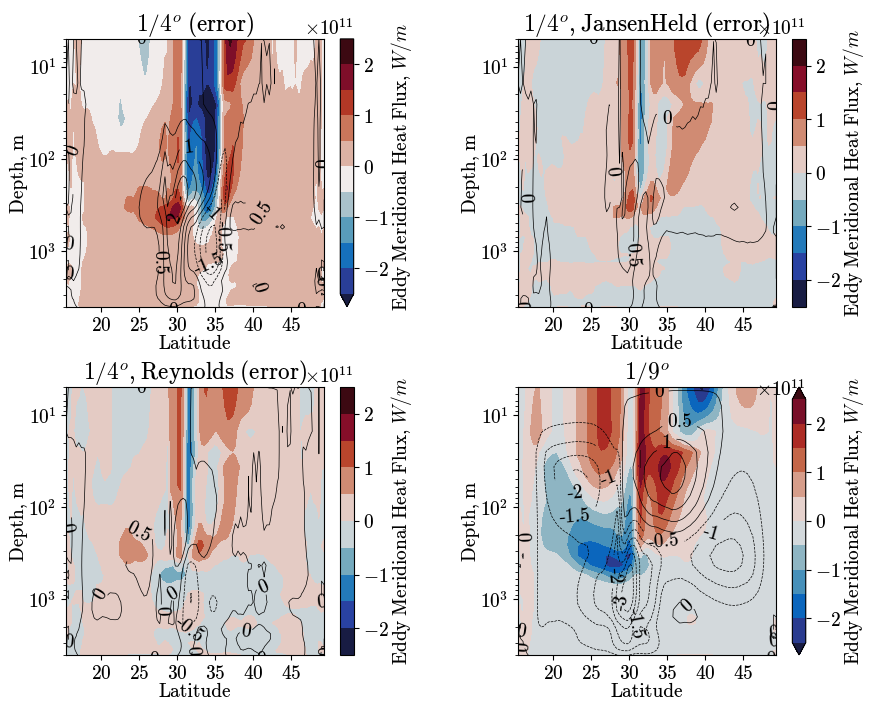

In [19]:
plot_2x2(Reynolds='CR_30_2iter_4boundary', error=True)

In [21]:
metrics().rank_metric('heat_flux2d')

{'R4_neg': '43.93 %',
 'CR_30_2iter_4boundary': '52.84 %',
 'CR_25_2iter_4boundary': '54.86 %',
 'CR_25_3iter': '57.47 %',
 'CR_35_2_iter': '59.95 %',
 'CR_20': '60.28 %',
 'CR_25': '68.97 %',
 'CR_25_2iter': '76.67 %',
 'CR_20_2iter': '81.57 %',
 'R4': '100.0 %'}

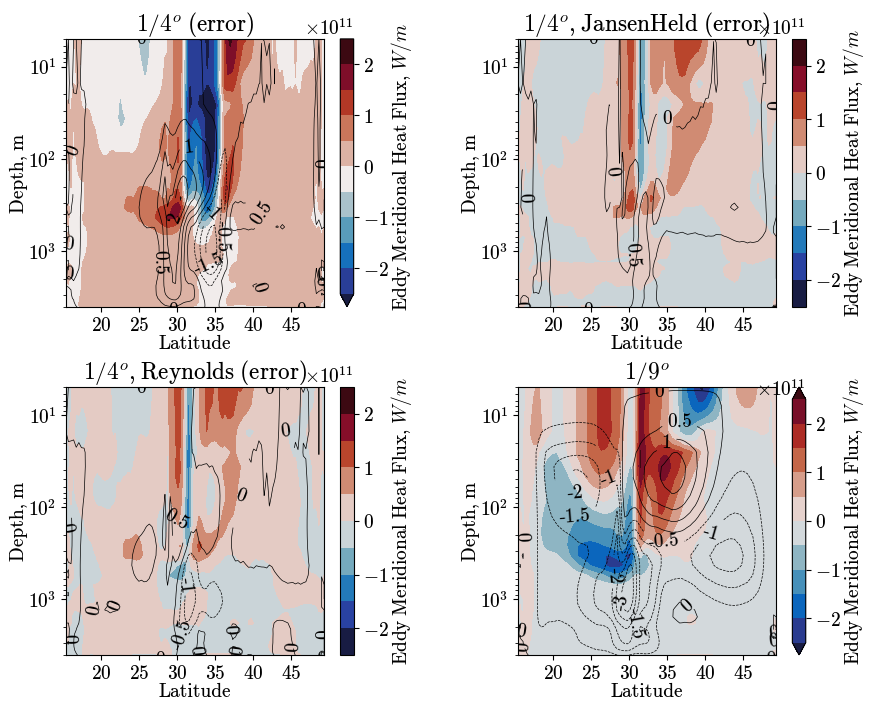

In [22]:
plot_2x2(Reynolds='CR_35_2iter_4boundary', error=True)

In [23]:
metrics().rank_metric('heat_flux')

{'CR_30_2iter_4boundary': '34.16 %',
 'R4_neg': '35.49 %',
 'CR_20': '36.73 %',
 'CR_25_3iter': '40.05 %',
 'CR_25_2iter_4boundary': '44.86 %',
 'CR_25': '45.71 %',
 'CR_35_2_iter': '53.42 %',
 'CR_25_2iter': '77.78 %',
 'CR_20_2iter': '83.69 %',
 'R4': '100.0 %'}

(-130000000000000.0, 50000000000000.0)

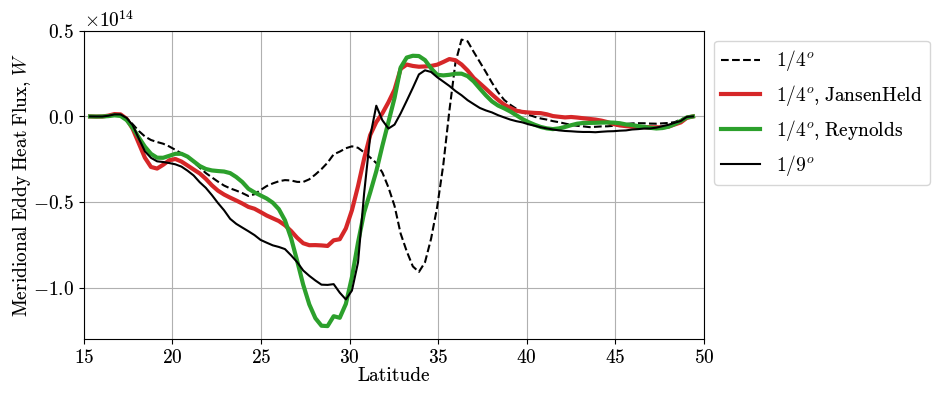

In [24]:
plt.figure(figsize=(8,4))
ds['R4'].heat_flux.plot(label='$1/4^o$', color='k', ls='--')
ds['R4_neg'].heat_flux.plot(label='$1/4^o$, JansenHeld', color='tab:red', lw=3)
ds['CR_30_2iter_4boundary'].heat_flux.plot(label='$1/4^o$, Reynolds', color='tab:green', lw=3)
ds['R9'].heat_flux.plot(label='$1/9^o$', color='k')
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel('Latitude')
plt.ylabel('Meridional Eddy Heat Flux, $W$')
plt.grid()
plt.xlim([15,50])
plt.ylim([-1.3e+14,0.5e+14])

In [25]:
metrics().rank_metric('EKE_ratio', normalize=False)

{'R4': 0.32,
 'CR_20_2iter': 0.65,
 'CR_25_2iter': 0.75,
 'CR_35_2_iter': 0.91,
 'CR_25_2iter_4boundary': 0.91,
 'CR_30_2iter_4boundary': 1.03,
 'R4_neg': 1.11,
 'CR_25_3iter': 1.13,
 'CR_20': 1.29,
 'CR_25': 1.47}

In [26]:
metrics().rank_metric('EKEz')

{'CR_30_2iter_4boundary': '10.3 %',
 'CR_25_2iter_4boundary': '12.07 %',
 'CR_35_2_iter': '12.79 %',
 'R4_neg': '20.57 %',
 'CR_25_3iter': '29.53 %',
 'CR_25_2iter': '34.97 %',
 'CR_20_2iter': '49.01 %',
 'CR_20': '51.97 %',
 'CR_25': '80.17 %',
 'R4': '100.0 %'}

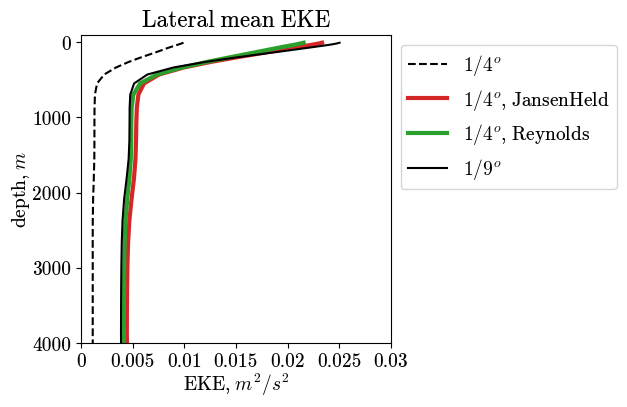

In [27]:
ds['R4'].plot_EKEz(label='$1/4^o$', color='k', ls='--')
ds['R4_neg'].plot_EKEz(label='$1/4^o$, JansenHeld', color='tab:red', lw=3)
ds['CR_30_2iter_4boundary'].plot_EKEz(label='$1/4^o$, Reynolds', color='tab:green', lw=3)
ds['R9'].plot_EKEz(label='$1/9^o$', color='k')
plt.legend(bbox_to_anchor=(1,1))

In [28]:
metrics().rank_metric('EKE_spectrum')

{'R4_neg': '21.29 %',
 'CR_30_2iter_4boundary': '33.94 %',
 'CR_25_2iter_4boundary': '45.79 %',
 'CR_20': '46.62 %',
 'CR_20_2iter': '49.07 %',
 'CR_25_3iter': '49.76 %',
 'CR_35_2_iter': '50.89 %',
 'CR_25': '50.99 %',
 'CR_25_2iter': '55.32 %',
 'R4': '100.0 %'}

Text(0.5, 1.0, 'Surface EKE spectrum')

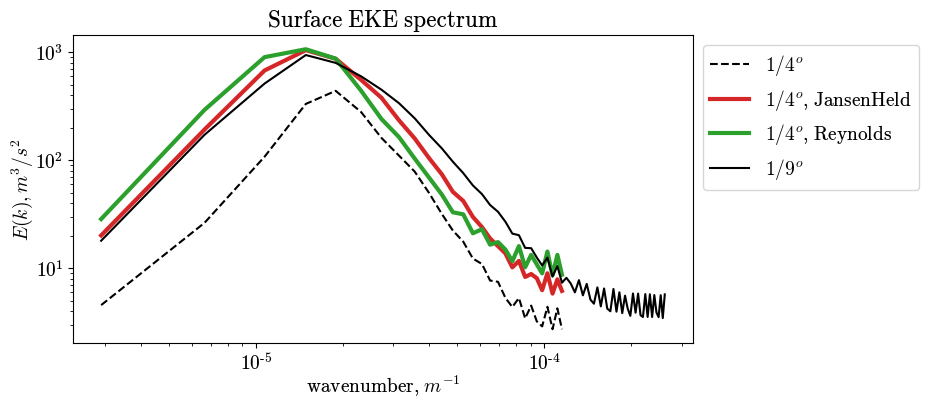

In [30]:
plt.figure(figsize=(8,4))
ds['R4'].EKE_spectrum.plot(label='$1/4^o$', color='k', ls='--')
ds['R4_neg'].EKE_spectrum.plot(label='$1/4^o$, JansenHeld', color='tab:red', lw=3)
ds['CR_30_2iter_4boundary'].EKE_spectrum.plot(label='$1/4^o$, Reynolds', color='tab:green', lw=3)
ds['R9'].EKE_spectrum.plot(label='$1/9^o$', color='k')
plt.legend(bbox_to_anchor=(1,1))
plt.xlabel('wavenumber, $m^{-1}$')
plt.ylabel('$E(k), m^3/s^2$')
plt.xscale('log')
plt.yscale('log')
plt.title('Surface EKE spectrum')

In [31]:
metrics().rank_metric('EKEs')

{'CR_20': '51.39 %',
 'R4_neg': '54.2 %',
 'CR_25_3iter': '57.0 %',
 'CR_25': '58.8 %',
 'CR_30_2iter_4boundary': '60.36 %',
 'CR_25_2iter_4boundary': '66.63 %',
 'CR_35_2_iter': '69.72 %',
 'CR_25_2iter': '82.02 %',
 'CR_20_2iter': '87.44 %',
 'R4': '100.0 %'}

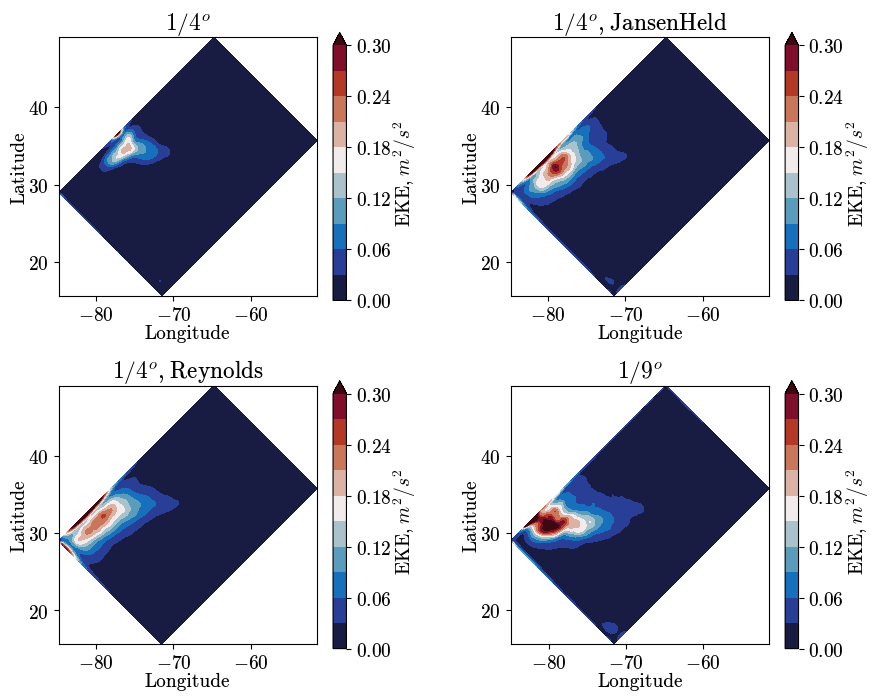

In [32]:
plot_2x2(fun='plot_EKE', Reynolds='CR_20')

In [33]:
metrics().rank_metric('SST')

{'CR_25': '35.59 %',
 'CR_20': '41.28 %',
 'CR_25_3iter': '46.19 %',
 'CR_30_2iter_4boundary': '49.62 %',
 'CR_35_2_iter': '54.22 %',
 'CR_25_2iter_4boundary': '54.63 %',
 'R4_neg': '62.4 %',
 'CR_25_2iter': '63.37 %',
 'CR_20_2iter': '68.58 %',
 'R4': '100.0 %'}

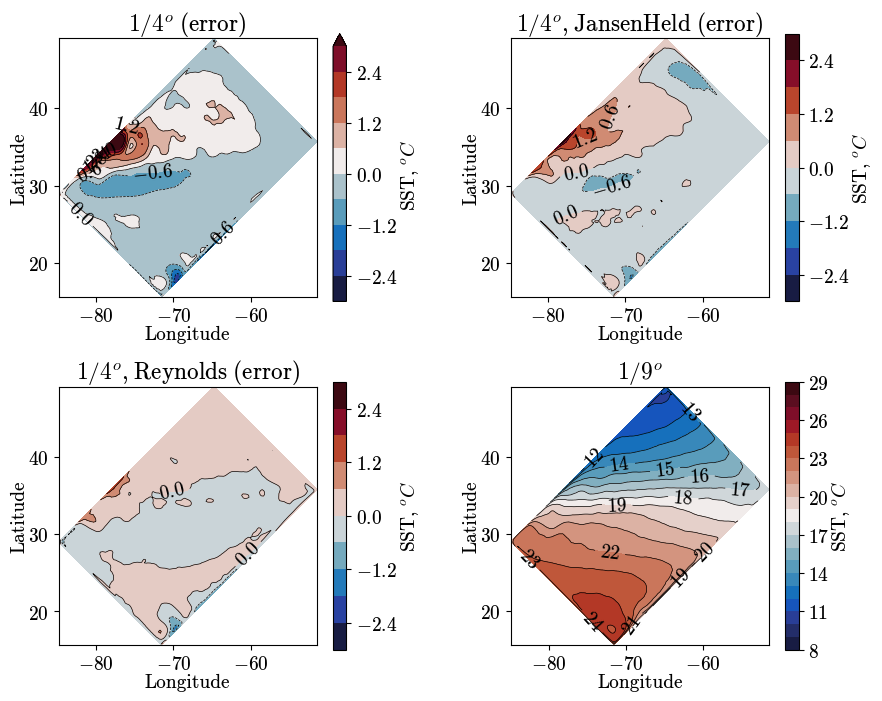

In [36]:
plot_2x2(fun='plot_SST', Reynolds='CR_25', error=True)

In [37]:
metrics().rank_metric('SSH')

{'CR_25': '44.83 %',
 'CR_20': '47.68 %',
 'CR_25_3iter': '54.53 %',
 'R4_neg': '55.82 %',
 'CR_30_2iter_4boundary': '56.36 %',
 'CR_25_2iter_4boundary': '64.44 %',
 'CR_35_2_iter': '66.36 %',
 'CR_25_2iter': '77.58 %',
 'CR_20_2iter': '83.76 %',
 'R4': '100.0 %'}

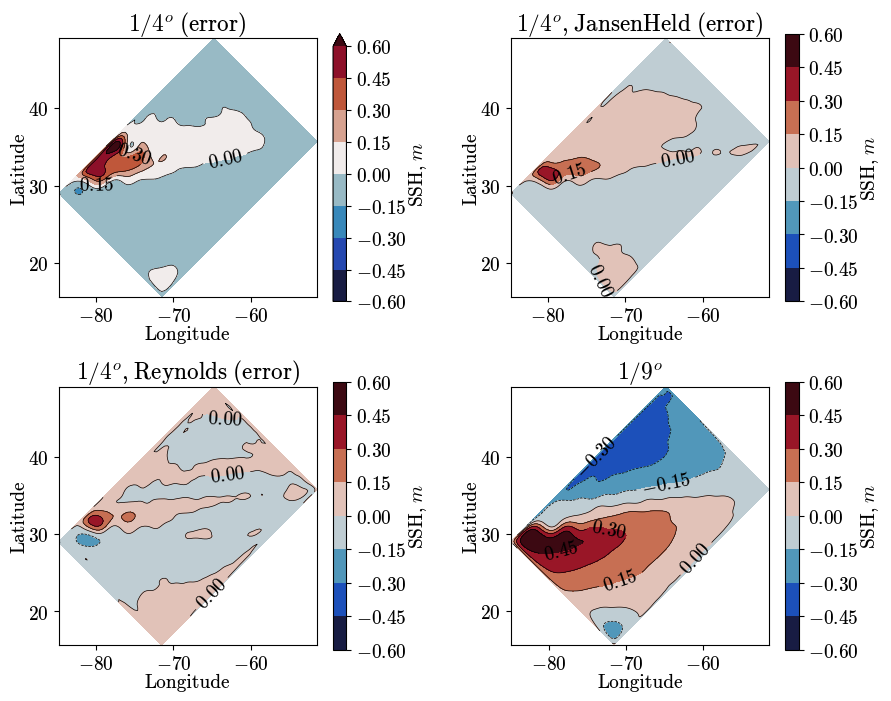

In [40]:
plot_2x2(fun='plot_SSH', Reynolds='CR_25', error=True)

In [41]:
metrics().rank_metric('uzonal_section')

{'R4_neg': '52.1 %',
 'CR_20': '61.76 %',
 'CR_30_2iter_4boundary': '67.88 %',
 'CR_25_3iter': '68.06 %',
 'CR_25_2iter_4boundary': '70.1 %',
 'CR_25': '72.34 %',
 'CR_35_2_iter': '72.55 %',
 'CR_20_2iter': '75.14 %',
 'CR_25_2iter': '81.39 %',
 'R4': '100.0 %'}

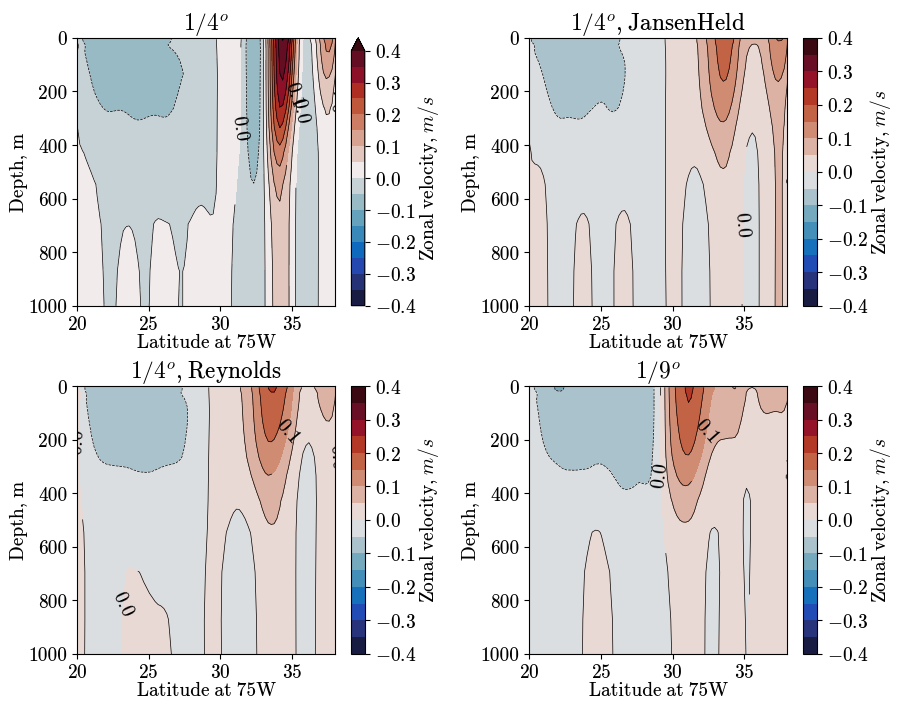

In [42]:
plot_2x2(fun='plot_uzonal_section', Reynolds='CR_20')

In [43]:
metrics().rank_metric('Tzonal_section')

{'CR_25': '55.68 %',
 'CR_25_3iter': '64.69 %',
 'CR_20': '65.31 %',
 'CR_30_2iter_4boundary': '73.53 %',
 'CR_35_2_iter': '77.32 %',
 'CR_25_2iter_4boundary': '87.41 %',
 'CR_25_2iter': '88.55 %',
 'R4_neg': '88.7 %',
 'CR_20_2iter': '94.37 %',
 'R4': '100.0 %'}

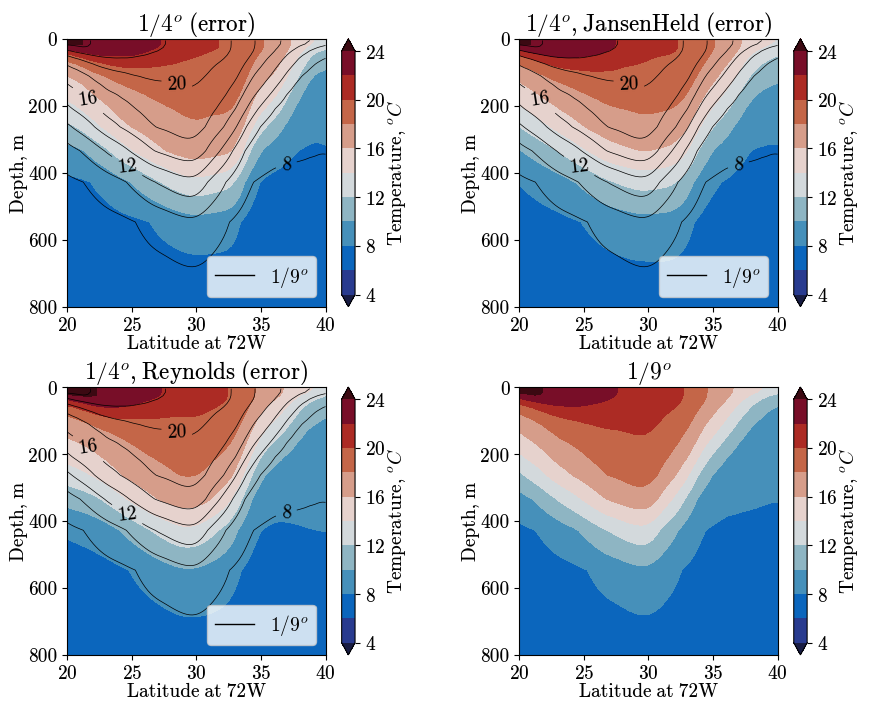

In [48]:
plot_2x2(fun='plot_Tzonal_section', Reynolds='CR_25', error=True)